In [1]:
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.12.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import requests
import io

### Load and explore NER data set

In [3]:
# import pandas as pd
# df = pd.read_csv('ner_dataset.csv', encoding='latin1')
# df = df.fillna(method='ffill')
# df.head(20)

In [4]:
url = 'https://github.com/Sarangm3/NER/raw/master/ner_dataset.csv'
response = requests.get(url)
df = pd.read_csv(io.StringIO(response.text))
df = df.fillna(method='ffill')
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


### **Data Preprocessing**

---



In [5]:
print('Unique words in corpus: ', df['Word'].nunique())
print('Unique tags in corpus: ', df['Tag'].nunique())

Unique words in corpus:  35172
Unique tags in corpus:  17


##Make all word unique in columns

In [6]:
words = list(set(df['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [7]:
tags = list(set(df['Tag'].values))
num_tags = len(tags)

In [8]:
tags

['I-gpe',
 'B-art',
 'I-tim',
 'B-gpe',
 'I-org',
 'O',
 'B-per',
 'I-art',
 'B-tim',
 'B-geo',
 'I-per',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-geo',
 'B-org']

In [9]:
num_words, num_tags

(35173, 17)

### Retrieve sentences and corresponding tags

In [10]:
class SentenceGetter(object):
    def __init__(self, df):
        self.n_sent = 1
        self.df = df
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                          s['POS'].values.tolist(),
                                                          s['Tag'].values.tolist())] # return tuple of three value take row as input 
        self.grouped = self.df.groupby('Sentence #').apply(agg_func) # group all row by sentence then apply agg_func for all row from sentence return group of all sentence
        self.sentences = list(self.grouped)

In [11]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [12]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Define mappings between sentences and tags

In [13]:
word2idx = {w: i+1 for i, w in enumerate(words)} # return dict of mapping number : index
tag2idx = {t: i for i, t in enumerate(tags)}

### Padding input sentences and creating train/test split

In [14]:
len(sentences)

47959

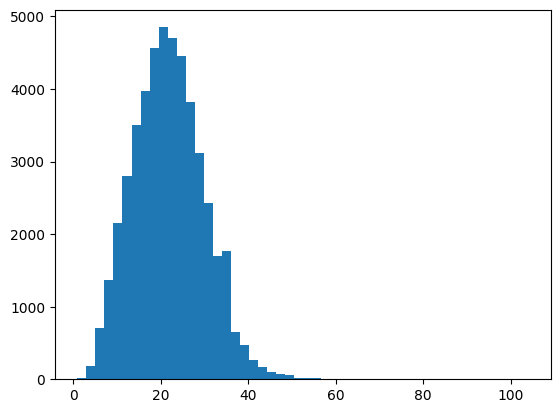

In [15]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show();

In [16]:
sentences[0][0]

('Thousands', 'NNS', 'O')

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50 #because there few sentences is bigger then that
X = [[word2idx[w[0]] for w in s] for s in sentences] # return index for all word from sentense store in array 
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)# give padding after 50 and use second last word as padding

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y] # return one-hot encoded vectors because we use normal integer then model may bais

In [18]:
len(y)

47959

In [19]:
X.shape 

(47959, 50)

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [21]:
x_train.shape

(43163, 50)

### Build and compile a Bidirectional LSTM model

In [22]:
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM,Bidirectional, TimeDistributed ,Dense

In [23]:
# model = Sequential([
#     Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len),
#     SpatialDropout1D(0.1),
#     Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)),
#     TimeDistributed(Dense(num_tags, activation='softmax'))
# ])

# model.summary()
input_word = Input(shape=(max_len, ))

#https://www.youtube.com/watch?v=sZGuyTLjsco for ////embedding
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)

model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758650   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [25]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 3,
    verbose = 1,
#    callbacks = callbacks
)

Epoch 1/3
1080/1080 [==============================] - 459s 413ms/step - loss: 0.1899 - accuracy: 0.9569 - val_loss: 0.0694 - val_accuracy: 0.9801
Epoch 2/3
1080/1080 [==============================] - 403s 373ms/step - loss: 0.0538 - accuracy: 0.9843 - val_loss: 0.0524 - val_accuracy: 0.9842
Epoch 3/3
1080/1080 [==============================] - 402s 372ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0470 - val_accuracy: 0.9856


### Evaluate Named Entity Recognition model

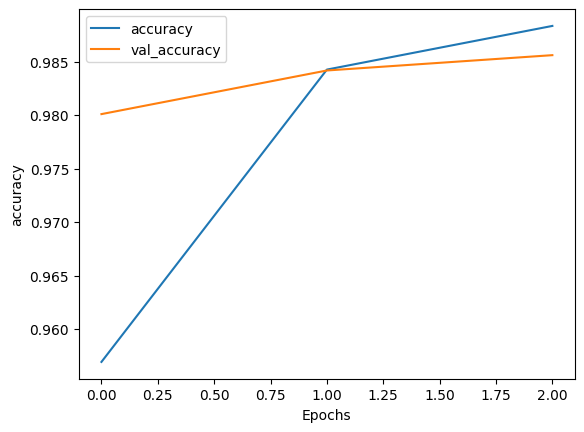

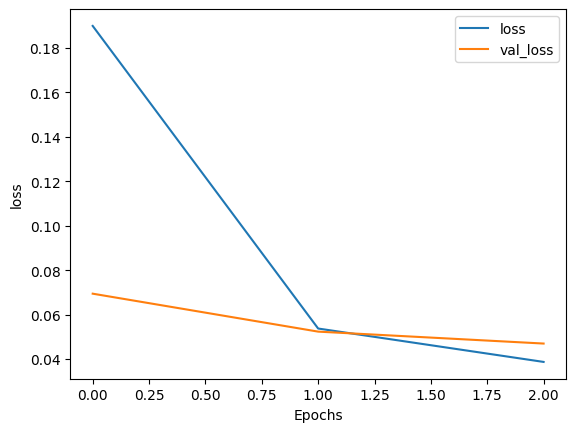

In [28]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [29]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 5s 36ms/step - loss: 0.0485 - accuracy: 0.9855


[0.04847508296370506, 0.9855296015739441]

In [30]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]

print('{:15}{:5}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[true], tags[pred]))

1/1 [==============================] - 1s 996ms/step
Word           True 	 Pred

------------------------------
The            O	O
previous       O	O
U.S.           B-geo	B-geo
champion       O	O
,              O	O
Disturbia      B-per	B-geo
,              O	O
ranked         O	O
a              O	O
distant        O	O
second         O	O
last           O	O
weekend        B-tim	B-tim
with           O	O
$              O	O
5.7            O	O
million        O	O
in             O	O
box            O	O
office         O	O
grosses        O	O
.              O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam          O	O
Humam    